# 🔊 AudioMNIST

## **Diving into the Data**🤿

* The dataset consists of 30000 audio samples of spoken digits (0-9) of 60 folders and 500 files each.

* There is one directory per speaker holding the audio recordings.

* Additionally "audioMNIST_meta.txt" provides meta information such as gender or age of each speaker.

In [1]:
from IPython.core.display import display, HTML, Javascript

# ----- Notebook Theme -----
color_map = ['#6166B3', '#e8eff6', '#0b2553']

prompt = color_map[-1]
main_color = color_map[0]

css_file = '''

    div #notebook {
    background-color: white;
    line-height: 20px;
    }

    #notebook-container {
    %s
    margin-top: 2em;
    padding-top: 2em;
    border-top: 4px solid %s; /* light orange */
    -webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    }

    div .input {
    margin-bottom: 1em;
    }

    .rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
    color: %s; /* light orange */
    font-weight: 600;
    }

    div.input_area {
    border: none;
        background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
        border-top: 2px solid %s; /* light orange */
    }

    div.input_prompt {
    color: %s; /* light blue */
    }

    div.output_prompt {
    color: %s; /* strong orange */
    }

    div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
    background: %s; /* light orange */
    }

    div.cell.selected, div.cell.selected.jupyter-soft-selected {
        border-color: %s; /* light orange */
    }

    .edit_mode div.cell.selected:before {
    background: %s; /* light orange */
    }

    .edit_mode div.cell.selected {
    border-color: %s; /* light orange */

    }
    '''
def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

/tmp/ipykernel_111802/111401022.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


## Importing Libraries🚀

In [2]:
# For Audio Preprocessing
import librosa
import librosa.display as dsp
from IPython.display import Audio

# For Data Preprocessing
import pandas as pd
import numpy as np
import os

# For data viz
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import scipy.io.wavfile as wavf
import scipy.signal

import glob

# transfer learning
import torch
from torchvision.models import resnet34
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

/home/fm/anaconda3/envs/TCI_FM/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sns.set_style("dark")

## Let's read and check some of the audio samples🔎

In [4]:
import os
os.getcwd()

'/home/fm/Documents/Diplomado IA & DL'

## Visualizing the spectogram of our audio data🔮

#### What is a spectogram ?

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.

Mel Spectrogram is the Spectrogram with non-linear transformation of the frequencies.

In [5]:
def plot_sounds_and_specgrams(infos):
    """
    """
    fig = plt.figure(figsize=(15, 30))
    subfigs = fig.subfigures(nrows=len(infos), ncols=1)
    
    for row, (subfig, info) in enumerate(zip(subfigs, infos)):
        (label, subject, trial) = info
        subfig.suptitle(f'Dígito {label}, Sujeto {subject}, Intento {trial}')
        
        axs = subfig.subplots(nrows=1, ncols=2)
        
        filepath = f"audio-mnist/data/{subject}/{label}_{subject}_{trial}.wav"
        dig, vp, rep = filepath.rstrip(".wav").split("/")[-1].split("_")
        # Lectura del archivo de audio
        fs, data = wavf.read(filepath)
        data = librosa.core.resample(y=data.astype(np.float32), orig_sr=fs, target_sr=8000, res_type="scipy")
        if len(data) > 8000:
            raise ValueError("data length cannot exceed padding length.")
        elif len(data) < 8000:
            embedded_data = np.zeros(8000)
            offset = np.random.randint(low = 0, high = 8000 - len(data))
            embedded_data[offset:offset+len(data)] = data
        elif len(data) == 8000:
            embedded_data = data
            pass
    
        ##### AlexNet #####
    
        # Aplica Short-Time-Fourier-Transformer para tranformar los datos,el espectrograma tendrá dimensiones (228,230)
        f, t, Zxx = scipy.signal.stft(embedded_data, 8000, nperseg = 455, noverlap = 420, window='hann')
        # get amplitude
        Zxx = np.abs(Zxx[0:227, 2:-1])
        #Zxx = np.atleast_3d(Zxx).transpose(2,0,1)
        # Convierte frecuencia a decibel
        #Zxx = librosa.amplitude_to_db(Zxx, ref = np.max)
        Zxx = librosa.amplitude_to_db(Zxx, ref = np.min)
        
        # Grafica la forma de onda 'waveform'
        librosa.display.waveshow(y=embedded_data, sr = len(embedded_data), ax=axs[0])
        axs[0].set_title('Waveform')
        axs[0].set_ylabel('Amplitude')

        # Grafica el espectrograma
        fig = librosa.display.specshow(Zxx,x_axis='time',y_axis='log', ax=axs[1])
        # Agrega la barra del color de la escala en dB
        plt.colorbar(fig,format ='%+2.0f dB')
        axs[1].set_title('Spectrogram')
        axs[1].set_ylabel('Frequency (Hz)')

        for ax in axs.flat:
            ax.set(xlabel='Time (s)')

In [6]:
subject_ids = [np.random.randint(1,60) for i in range(10)]
for i in range(10): 
    if subject_ids[i]<10:
        subject_ids[i] = "0"+str(subject_ids[i])
    else:
        subject_ids[i] = str(subject_ids[i])
        
labels = [str(j) for j in range(10)]
record_ids = [str(np.random.randint(1,50)) for k in range(10)]
infos = [(labels[i], subject_ids[i], record_ids[i]) for i in range(10)]

In [7]:
i = np.random.randint(1,10)
wav, sr = librosa.load(f"audio-mnist/data/{subject_ids[i]}/{labels[i]}_{subject_ids[i]}_{record_ids[i]}.wav", sr=None)
print(f'La rata de muestreo es {sr} y la longitud del audio es de {len(wav)/sr} segundos')

La rata de muestreo es 48000 y la longitud del audio es de 0.9305416666666667 segundos


In [8]:
i = np.random.randint(1,10)
#wav, sr = librosa.load(f"audio-mnist/data/{subject_ids[i]}/{labels[i]}_{subject_ids[i]}_{record_ids[i]}.wav", sr=None)
#fs, data = wavf.read(filepath)
wav, sr = librosa.load(f"audio-mnist/data/{subject_ids[i]}/{labels[i]}_{subject_ids[i]}_{record_ids[i]}.wav", sr=None)
wav = librosa.core.resample(y=wav.astype(np.float32), orig_sr=sr, target_sr=8000, res_type="scipy")
if len(wav) > 8000:
    raise ValueError("data length cannot exceed padding length.")
elif len(wav) < 8000:
    embedded_data = np.zeros(8000)
    offset = np.random.randint(low = 0, high = 8000 - len(wav))
    embedded_data[offset:offset+len(wav)] = wav
elif len(data) == 8000:
    embedded_data = wav
    pass

print(f'La rata de muestreo es {len(embedded_data)} y la longitud del audio es de {len(embedded_data)/len(embedded_data)} segundos')

La rata de muestreo es 8000 y la longitud del audio es de 1.0 segundos


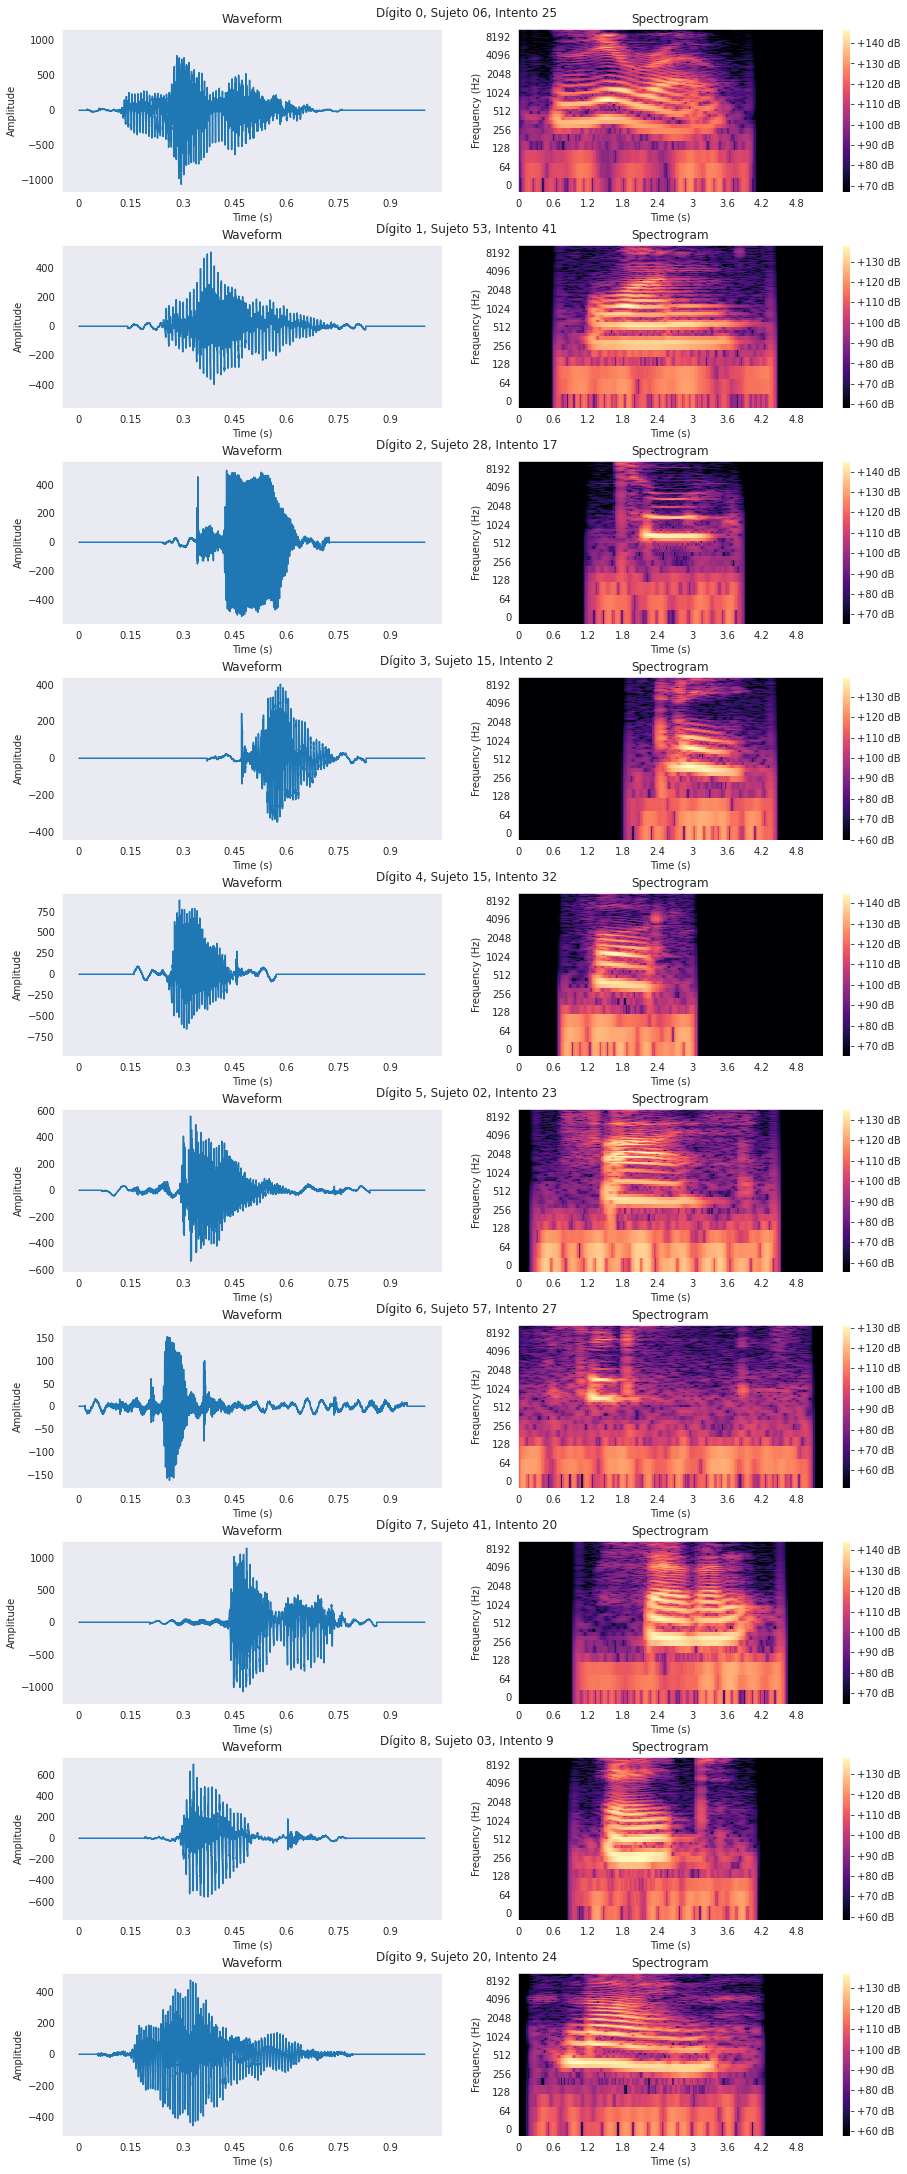

In [9]:
plot_sounds_and_specgrams(infos)

## Extracting features from the audio file🥤

#### Create a function that extracts the data from audio files

+ Split del paper

In [10]:
files = [x for x in sorted(glob.glob(os.path.join('audio-mnist/data', "**"), recursive = True)) if x.endswith('.wav')]

splits={"digit":{"train":[set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53, 36, 57,  9, 24, 37,  2,
                               8, 17, 29, 39, 48, 54, 43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55]),
                          set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54, 43, 58, 14, 25, 38,  3, 
                               10, 20, 30, 40, 49, 55, 12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50]),
                          set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55, 12, 47, 59, 15, 27, 41, 
                               4, 11, 21, 31, 44, 50, 26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),
                          set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50, 26, 52, 60, 18, 32, 42, 
                               5, 13, 22, 33, 45, 51, 28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),
                          set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51, 28, 56,  7, 19, 35,  1, 
                               6, 16, 23, 34, 46, 53, 36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54])],
                 
                 "validate":[set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50]),
                             set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),
                             set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),
                             set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54]),
                             set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55])],
                 
                 "test":[set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),
                         set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),
                         set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54]),
                         set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55]),
                         set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50])]}}

files_ = {'train':{'cv1':[], 'cv2':[], 'cv3':[], 'cv4':[], 'cv5':[]},
          'validate':{'cv1':[], 'cv2':[], 'cv3':[], 'cv4':[], 'cv5':[]},
          'test':{'cv1':[], 'cv2':[], 'cv3':[], 'cv4':[], 'cv5':[]}}

for i in files_.keys():
    """
    i in ['train', 'validate', 'test']
        k in ['cv1', 'cv2', 'cv3', 'cv4', 'cv5']
            j in [if i == 'train': [0,..., 35] else: [0,...,9]]
    """
    m = 0
    for k in files_[i].keys():
        for j in range(len(splits['digit'][i][m])):
            if list(splits['digit'][i][m])[j]<10:
                a = 'audio-mnist/data/0' + str(list(splits['digit'][i][m])[j])
            else:
                a = 'audio-mnist/data/' + str(list(splits['digit'][i][m])[j])  
            files_[i][k].append([y for y in files if y.startswith(a)]) 
        m += 1

In [11]:
print("Núm de arreglos:", len([len(files_[k][j][i]) for k in files_.keys()  for j in files_[k].keys() for i in range(len(files_[k][j]))]))
print("Núm de elementos únicos de cada arreglo:", np.unique([len(files_[k][j][i]) for k in files_.keys()  for j in files_[k].keys() for i in range(len(files_[k][j]))]))

Núm de arreglos: 300
Núm de elementos únicos de cada arreglo: [500]


In [12]:
files_['train']['cv5'][0][-6:] # últimos 6 elementos de las rutas del dígito 1 en el 'cv5' del conjunto 'train'

['audio-mnist/data/01/9_01_49.wav',
 'audio-mnist/data/01/9_01_5.wav',
 'audio-mnist/data/01/9_01_6.wav',
 'audio-mnist/data/01/9_01_7.wav',
 'audio-mnist/data/01/9_01_8.wav',
 'audio-mnist/data/01/9_01_9.wav']

In [13]:
files_.keys() #['train', 'validate', 'test']
files_['train'].keys() #['cv1', 'cv2', 'cv3', 'cv4', 'cv5']
len(files_['train']['cv1']) # 36 folders
len(files_['train']['cv1'][0]) # 500 audio files

500

In [14]:
df = pd.DataFrame({'filename':files_['train']['cv1'][0]})
df['category'] = [df['filename'][i].rstrip(".wav").split("/")[-1].split("_")[0] for i in range(len(df['filename']))]
df.tail()

,filename,category
495,audio-mnist/data/01/9_01_5.wav,9
496,audio-mnist/data/01/9_01_6.wav,9
497,audio-mnist/data/01/9_01_7.wav,9
498,audio-mnist/data/01/9_01_8.wav,9
499,audio-mnist/data/01/9_01_9.wav,9


+ [preprocesamiento diplomado](https://github.com/jofmorenore/Diplomado-Avanzado/blob/main/Visi%C3%B3n%20Artificial/Cuadernos/tratamiento_audios.ipynb)

In [15]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    #sr= rata de muestreo
    #n_fft= número de muestras para cada ventana
    #hop_length= número de muestras que se salta para la siguiente ventana de tiempo
    #n_mel= número de filtros de mel, o la altura de la imagen del espectrograma
  wav, sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<1*sr:
    wav=np.pad(wav,int(np.ceil((1*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:1*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [16]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

/tmp/ipykernel_111802/1208370464.py:11: FutureWarning: Pass y=[-0.00042725 -0.00039673 -0.00021362 ... -0.00219727 -0.00308228
 -0.00384521] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,


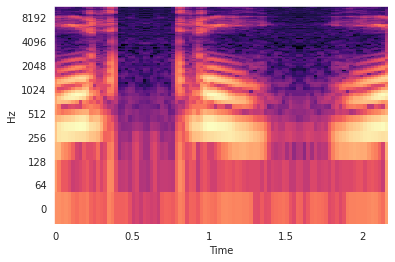

In [17]:
i = np.random.randint(1,10)
filepath = f"audio-mnist/data/{subject_ids[i]}/{labels[i]}_{subject_ids[i]}_{record_ids[i]}.wav"
gms = get_melspectrogram_db(file_path=filepath)
librosa.display.specshow(gms,x_axis='time',y_axis='log')

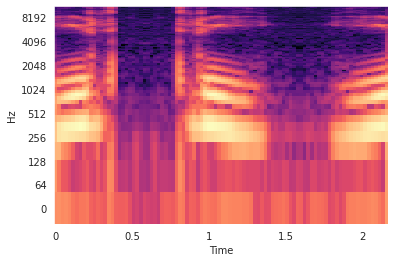

In [18]:
librosa.display.specshow(spec_to_image(gms),x_axis='time',y_axis='log')

In [19]:
class AudioMNISTData(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df #base de datos con información
    self.data = [] #las imagenes nuevas que vamos a generar
    self.labels = [] #las categorías de las respectivas imagenes
    self.c2i={} #diccionario de característica a índice
    self.i2c={} #diccionario de índice a característica
    self.categories = sorted(df[out_col].unique()) #valores únicos de las categorías, deben ser 50
    for i, category in enumerate(self.categories): #agregamos los valores a los diccionarios
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))): #otra forma de enumerate pero agregando barras de progreso al loop
      row = df.iloc[ind] #iteramos sobre cada fila
      file_path = os.path.join(base,row[in_col]) #buscamos el nombre del archivo y obtenemos la dirección
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...]) #esto es lo mismo que escribir  [np.newaxis,:, :, :]
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [ ]:
df = pd.DataFrame({'filename':files_['train']['cv1'][0]})
df['category'] = [df['filename'][i].rstrip(".wav").split("/")[-1].split("_")[0] for i in range(len(df['filename']))]

df2 = pd.DataFrame({'filename':files_['validate']['cv1'][0]})
df2['category'] = [df2['filename'][i].rstrip(".wav").split("/")[-1].split("_")[0] for i in range(len(df['filename']))]


train_data = AudioMNISTData(os.getcwd(), df, 'filename', 'category')
valid_data = AudioMNISTData(os.getcwd(), df2, 'filename', 'category')
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

## [ResNet-34 Pre-trained Model for PyTorch](https://www.kaggle.com/datasets/pytorch/resnet34)

In [21]:
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/home/fm/anaconda3/envs/TCI_FM/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fm/anaconda3/envs/TCI_FM/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


![ResNEt34](https://i.imgur.com/nyYh5xH.png)

In [22]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [23]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [24]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.7781620022724383


  2%|▉                                           | 1/50 [00:03<02:32,  3.10s/it]

Epoch - 1 Valid-Loss : 0.3799976212903857 Valid-Accuracy : 0.9
Epoch - 2 Train-Loss : 0.09904244642530102


  4%|█▊                                          | 2/50 [00:05<02:04,  2.59s/it]

Epoch - 2 Valid-Loss : 0.4361379980109632 Valid-Accuracy : 0.866
Epoch - 3 Train-Loss : 0.0769091130423476


  6%|██▋                                         | 3/50 [00:07<01:54,  2.43s/it]

Epoch - 3 Valid-Loss : 0.8748090967746975 Valid-Accuracy : 0.748
Epoch - 4 Train-Loss : 0.09501430509408237


  8%|███▌                                        | 4/50 [00:09<01:48,  2.35s/it]

Epoch - 4 Valid-Loss : 0.6011468525393866 Valid-Accuracy : 0.81
Epoch - 5 Train-Loss : 0.09362338372739032


 10%|████▍                                       | 5/50 [00:12<01:44,  2.31s/it]

Epoch - 5 Valid-Loss : 0.6638037282973528 Valid-Accuracy : 0.824
Epoch - 6 Train-Loss : 0.05406858593050856


 12%|█████▎                                      | 6/50 [00:14<01:40,  2.29s/it]

Epoch - 6 Valid-Loss : 0.27613310196466045 Valid-Accuracy : 0.91
Epoch - 7 Train-Loss : 0.02960659232303442


 14%|██████▏                                     | 7/50 [00:16<01:37,  2.27s/it]

Epoch - 7 Valid-Loss : 0.29839420708594844 Valid-Accuracy : 0.902
Epoch - 8 Train-Loss : 0.054671651472745


 16%|███████                                     | 8/50 [00:18<01:35,  2.26s/it]

Epoch - 8 Valid-Loss : 0.7629451095126569 Valid-Accuracy : 0.776
Epoch - 9 Train-Loss : 0.055219030273292447


 18%|███████▉                                    | 9/50 [00:21<01:32,  2.26s/it]

Epoch - 9 Valid-Loss : 0.6729333270632196 Valid-Accuracy : 0.814
Changed learning rate to 2e-05
Epoch - 10 Train-Loss : 0.021816736476466758


 20%|████████▌                                  | 10/50 [00:23<01:30,  2.25s/it]

Epoch - 10 Valid-Loss : 0.2565627282601781 Valid-Accuracy : 0.91
Epoch - 11 Train-Loss : 0.012719872052912251


 22%|█████████▍                                 | 11/50 [00:25<01:27,  2.25s/it]

Epoch - 11 Valid-Loss : 0.2790796955814585 Valid-Accuracy : 0.89
Epoch - 12 Train-Loss : 0.07367586448708607


 24%|██████████▎                                | 12/50 [00:27<01:25,  2.25s/it]

Epoch - 12 Valid-Loss : 0.1488911427441053 Valid-Accuracy : 0.942
Epoch - 13 Train-Loss : 0.01662627987752785


 26%|███████████▏                               | 13/50 [00:29<01:23,  2.25s/it]

Epoch - 13 Valid-Loss : 0.12562753830570728 Valid-Accuracy : 0.954
Epoch - 14 Train-Loss : 0.005218535332460306


 28%|████████████                               | 14/50 [00:32<01:20,  2.25s/it]

Epoch - 14 Valid-Loss : 0.07543666128185578 Valid-Accuracy : 0.984
Epoch - 15 Train-Loss : 0.027635529257167946


 30%|████████████▉                              | 15/50 [00:34<01:18,  2.24s/it]

Epoch - 15 Valid-Loss : 0.08835458921384998 Valid-Accuracy : 0.98
Epoch - 16 Train-Loss : 0.0034756307049974566


 32%|█████████████▊                             | 16/50 [00:36<01:16,  2.25s/it]

Epoch - 16 Valid-Loss : 0.09702233001007698 Valid-Accuracy : 0.976
Epoch - 17 Train-Loss : 0.0025617519049774273


 34%|██████████████▌                            | 17/50 [00:39<01:14,  2.26s/it]

Epoch - 17 Valid-Loss : 0.15484320017276332 Valid-Accuracy : 0.948
Epoch - 18 Train-Loss : 0.002838565202182508


 36%|███████████████▍                           | 18/50 [00:41<01:13,  2.29s/it]

Epoch - 18 Valid-Loss : 0.18001935935171787 Valid-Accuracy : 0.946
Epoch - 19 Train-Loss : 0.0035783154335149447


 38%|████████████████▎                          | 19/50 [00:43<01:11,  2.30s/it]

Epoch - 19 Valid-Loss : 0.16838919615838677 Valid-Accuracy : 0.96
Changed learning rate to 2e-06
Epoch - 20 Train-Loss : 0.002330343112589617


 40%|█████████████████▏                         | 20/50 [00:46<01:09,  2.31s/it]

Epoch - 20 Valid-Loss : 0.13111480746010784 Valid-Accuracy : 0.962
Epoch - 21 Train-Loss : 0.0163580770504268


 42%|██████████████████                         | 21/50 [00:48<01:07,  2.31s/it]

Epoch - 21 Valid-Loss : 0.18562338582705706 Valid-Accuracy : 0.946
Epoch - 22 Train-Loss : 0.002067465321488271


 44%|██████████████████▉                        | 22/50 [00:50<01:04,  2.32s/it]

Epoch - 22 Valid-Loss : 0.1221807079273276 Valid-Accuracy : 0.946
Epoch - 23 Train-Loss : 0.007720591259385401


 46%|███████████████████▊                       | 23/50 [00:53<01:02,  2.32s/it]

Epoch - 23 Valid-Loss : 0.10303462034426047 Valid-Accuracy : 0.964
Epoch - 24 Train-Loss : 0.018825361115887063


 48%|████████████████████▋                      | 24/50 [00:55<00:59,  2.30s/it]

Epoch - 24 Valid-Loss : 0.08685418415552704 Valid-Accuracy : 0.976
Epoch - 25 Train-Loss : 0.03582537724332724


 50%|█████████████████████▌                     | 25/50 [00:57<00:57,  2.31s/it]

Epoch - 25 Valid-Loss : 0.162074730367749 Valid-Accuracy : 0.946
Epoch - 26 Train-Loss : 0.008408933816099307


 52%|██████████████████████▎                    | 26/50 [00:59<00:55,  2.33s/it]

Epoch - 26 Valid-Loss : 0.10182664722378831 Valid-Accuracy : 0.972
Epoch - 27 Train-Loss : 0.006990926814069098


 54%|███████████████████████▏                   | 27/50 [01:02<00:53,  2.34s/it]

Epoch - 27 Valid-Loss : 0.16841218469198793 Valid-Accuracy : 0.948
Epoch - 28 Train-Loss : 0.004885606615971483


 56%|████████████████████████                   | 28/50 [01:04<00:51,  2.34s/it]

Epoch - 28 Valid-Loss : 0.20499726010166341 Valid-Accuracy : 0.936
Epoch - 29 Train-Loss : 0.003732445255081984


 58%|████████████████████████▉                  | 29/50 [01:06<00:48,  2.32s/it]

Epoch - 29 Valid-Loss : 0.19816990580875427 Valid-Accuracy : 0.94
Changed learning rate to 2.0000000000000002e-07
Epoch - 30 Train-Loss : 0.009072132545043132


 60%|█████████████████████████▊                 | 30/50 [01:09<00:46,  2.31s/it]

Epoch - 30 Valid-Loss : 0.12825284383143298 Valid-Accuracy : 0.956
Epoch - 31 Train-Loss : 0.002697183532291092


 62%|██████████████████████████▋                | 31/50 [01:11<00:43,  2.30s/it]

Epoch - 31 Valid-Loss : 0.13863026909530163 Valid-Accuracy : 0.956
Epoch - 32 Train-Loss : 0.0041137790631182725


 64%|███████████████████████████▌               | 32/50 [01:13<00:41,  2.28s/it]

Epoch - 32 Valid-Loss : 0.16458413493819535 Valid-Accuracy : 0.95
Epoch - 33 Train-Loss : 0.002288719314037735


 66%|████████████████████████████▍              | 33/50 [01:16<00:38,  2.28s/it]

Epoch - 33 Valid-Loss : 0.16162627105950378 Valid-Accuracy : 0.942
Epoch - 34 Train-Loss : 0.0016219096014538081


 68%|█████████████████████████████▏             | 34/50 [01:18<00:36,  2.27s/it]

Epoch - 34 Valid-Loss : 0.22327702294569463 Valid-Accuracy : 0.924
Epoch - 35 Train-Loss : 0.001164956493084901


 70%|██████████████████████████████             | 35/50 [01:20<00:34,  2.29s/it]

Epoch - 35 Valid-Loss : 0.12489348568487912 Valid-Accuracy : 0.964
Epoch - 36 Train-Loss : 0.007412624603603035


 72%|██████████████████████████████▉            | 36/50 [01:22<00:32,  2.30s/it]

Epoch - 36 Valid-Loss : 0.1556231766444398 Valid-Accuracy : 0.948
Epoch - 37 Train-Loss : 0.0014791212497584638


 74%|███████████████████████████████▊           | 37/50 [01:25<00:29,  2.29s/it]

Epoch - 37 Valid-Loss : 0.14097134841722436 Valid-Accuracy : 0.96
Epoch - 38 Train-Loss : 0.011530565211614885


 76%|████████████████████████████████▋          | 38/50 [01:27<00:27,  2.29s/it]

Epoch - 38 Valid-Loss : 0.11033981353830313 Valid-Accuracy : 0.964
Epoch - 39 Train-Loss : 0.0064419835744047305


 78%|█████████████████████████████████▌         | 39/50 [01:29<00:25,  2.29s/it]

Epoch - 39 Valid-Loss : 0.13222759080235846 Valid-Accuracy : 0.958
Changed learning rate to 2e-08
Epoch - 40 Train-Loss : 0.0027080483923782595


 80%|██████████████████████████████████▍        | 40/50 [01:32<00:23,  2.30s/it]

Epoch - 40 Valid-Loss : 0.18951779267808888 Valid-Accuracy : 0.936
Epoch - 41 Train-Loss : 0.003661246385490813


 82%|███████████████████████████████████▎       | 41/50 [01:34<00:20,  2.29s/it]

Epoch - 41 Valid-Loss : 0.17777001549256966 Valid-Accuracy : 0.954
Epoch - 42 Train-Loss : 0.0014249008081606007


 84%|████████████████████████████████████       | 42/50 [01:36<00:18,  2.28s/it]

Epoch - 42 Valid-Loss : 0.10519154314533807 Valid-Accuracy : 0.968
Epoch - 43 Train-Loss : 0.00210600440914277


 86%|████████████████████████████████████▉      | 43/50 [01:38<00:15,  2.27s/it]

Epoch - 43 Valid-Loss : 0.1793767604394816 Valid-Accuracy : 0.934
Epoch - 44 Train-Loss : 0.00342387369255448


 88%|█████████████████████████████████████▊     | 44/50 [01:41<00:13,  2.26s/it]

Epoch - 44 Valid-Loss : 0.12680379702942446 Valid-Accuracy : 0.95
Epoch - 45 Train-Loss : 0.0018404526217636885


 90%|██████████████████████████████████████▋    | 45/50 [01:43<00:11,  2.26s/it]

Epoch - 45 Valid-Loss : 0.1705453483009478 Valid-Accuracy : 0.938
Epoch - 46 Train-Loss : 0.09543835814201884


 92%|███████████████████████████████████████▌   | 46/50 [01:45<00:09,  2.25s/it]

Epoch - 46 Valid-Loss : 0.18246662194906094 Valid-Accuracy : 0.946
Epoch - 47 Train-Loss : 0.005104083308651752


 94%|████████████████████████████████████████▍  | 47/50 [01:47<00:06,  2.25s/it]

Epoch - 47 Valid-Loss : 0.15471130668083788 Valid-Accuracy : 0.952
Epoch - 48 Train-Loss : 0.005680719147676427


 96%|█████████████████████████████████████████▎ | 48/50 [01:50<00:04,  2.25s/it]

Epoch - 48 Valid-Loss : 0.07244135042856215 Valid-Accuracy : 0.98
Epoch - 49 Train-Loss : 0.0020410285160323838


 98%|██████████████████████████████████████████▏| 49/50 [01:52<00:02,  2.25s/it]

Epoch - 49 Valid-Loss : 0.19706106802914292 Valid-Accuracy : 0.934
Changed learning rate to 2e-09
Epoch - 50 Train-Loss : 0.0016023207826947328


100%|███████████████████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]

Epoch - 50 Valid-Loss : 0.10337988743413007 Valid-Accuracy : 0.968


+ preprocesamiento paper

In [25]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    #sr= rata de muestreo
    #n_fft= número de muestras para cada ventana
    #hop_length= número de muestras que se salta para la siguiente ventana de tiempo
    #n_mel= número de filtros de mel, o la altura de la imagen del espectrograma
    sr, wav = wavf.read(file_path)
    wav = librosa.core.resample(y=wav.astype(np.float32), orig_sr=sr, target_sr=8000, res_type="scipy")
    if len(wav) > 8000:
        raise ValueError("data length cannot exceed padding length.")
    elif len(wav) < 8000:
        embedded_data = np.zeros(8000)
        offset = np.random.randint(low = 0, high = 8000 - len(wav))
        embedded_data[offset:offset+len(wav)] = wav
    elif len(wav) == 8000:
            embedded_data = wav
            pass
    
    ##### AlexNet #####
    
    # Aplica Short-Time-Fourier-Transformer para tranformar los datos,el espectrograma tendrá dimensiones (228,230)
    f, t, Zxx = scipy.signal.stft(embedded_data, 8000, nperseg = 455, noverlap = 420, window='hann')
    # get amplitude
    Zxx = np.abs(Zxx[0:227, 2:-1])
    #Zxx = np.atleast_3d(Zxx).transpose(2,0,1)
    # Convierte frecuencia a decibel
    #Zxx = librosa.amplitude_to_db(Zxx, ref = np.max)
    Zxx = librosa.amplitude_to_db(Zxx, ref = np.min)
    return Zxx

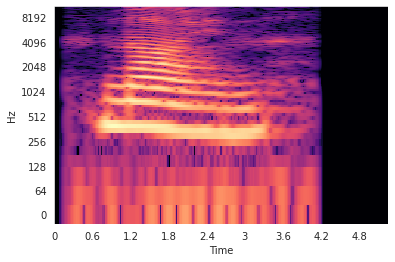

In [26]:
i = np.random.randint(1,10)
filepath = f"audio-mnist/data/{subject_ids[i]}/{labels[i]}_{subject_ids[i]}_{record_ids[i]}.wav"
gms = get_melspectrogram_db(file_path=filepath)
librosa.display.specshow(gms,x_axis='time',y_axis='log')

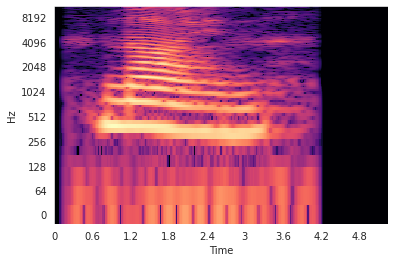

In [27]:
librosa.display.specshow(spec_to_image(gms),x_axis='time',y_axis='log')

In [28]:
import torch.optim as optim

learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.02950884335768933


  2%|▉                                           | 1/50 [00:02<01:53,  2.31s/it]

Epoch - 1 Valid-Loss : 1.068328585010022 Valid-Accuracy : 0.788
Epoch - 2 Train-Loss : 0.18684592236968456


  4%|█▊                                          | 2/50 [00:04<01:49,  2.29s/it]

Epoch - 2 Valid-Loss : 0.49207437701988965 Valid-Accuracy : 0.856
Epoch - 3 Train-Loss : 0.10898803717282135


  6%|██▋                                         | 3/50 [00:06<01:46,  2.27s/it]

Epoch - 3 Valid-Loss : 0.30232839356176555 Valid-Accuracy : 0.904
Epoch - 4 Train-Loss : 0.039294173982852953


  8%|███▌                                        | 4/50 [00:09<01:43,  2.26s/it]

Epoch - 4 Valid-Loss : 0.33085201896028593 Valid-Accuracy : 0.896
Epoch - 5 Train-Loss : 0.03401629023028363


 10%|████▍                                       | 5/50 [00:11<01:41,  2.26s/it]

Epoch - 5 Valid-Loss : 0.25415239164431114 Valid-Accuracy : 0.898
Epoch - 6 Train-Loss : 0.013969754216532237


 12%|█████▎                                      | 6/50 [00:13<01:39,  2.25s/it]

Epoch - 6 Valid-Loss : 0.3902119114791276 Valid-Accuracy : 0.854
Epoch - 7 Train-Loss : 0.0031773107748449547


 14%|██████▏                                     | 7/50 [00:15<01:36,  2.25s/it]

Epoch - 7 Valid-Loss : 0.20890340930782259 Valid-Accuracy : 0.922
Epoch - 8 Train-Loss : 0.020897487559523142


 16%|███████                                     | 8/50 [00:18<01:34,  2.25s/it]

Epoch - 8 Valid-Loss : 0.27539815596537665 Valid-Accuracy : 0.906
Epoch - 9 Train-Loss : 0.04193845823965603


 18%|███████▉                                    | 9/50 [00:20<01:32,  2.25s/it]

Epoch - 9 Valid-Loss : 0.5713461434934288 Valid-Accuracy : 0.808
Changed learning rate to 2e-05
Epoch - 10 Train-Loss : 0.009999299501942005


 20%|████████▌                                  | 10/50 [00:22<01:30,  2.25s/it]

Epoch - 10 Valid-Loss : 0.3250495956162922 Valid-Accuracy : 0.868
Epoch - 11 Train-Loss : 0.004109933698600798


 22%|█████████▍                                 | 11/50 [00:24<01:27,  2.25s/it]

Epoch - 11 Valid-Loss : 0.36009225714951754 Valid-Accuracy : 0.884
Epoch - 12 Train-Loss : 0.005490109102538554


 24%|██████████▎                                | 12/50 [00:27<01:25,  2.25s/it]

Epoch - 12 Valid-Loss : 0.3720712454523891 Valid-Accuracy : 0.878
Epoch - 13 Train-Loss : 0.001896493628009921


 26%|███████████▏                               | 13/50 [00:29<01:23,  2.25s/it]

Epoch - 13 Valid-Loss : 0.3807116998359561 Valid-Accuracy : 0.866
Epoch - 14 Train-Loss : 0.05930676126627077


 28%|████████████                               | 14/50 [00:31<01:21,  2.25s/it]

Epoch - 14 Valid-Loss : 0.4112793125677854 Valid-Accuracy : 0.878
Epoch - 15 Train-Loss : 0.001488497387526877


 30%|████████████▉                              | 15/50 [00:33<01:19,  2.26s/it]

Epoch - 15 Valid-Loss : 0.2694019010523334 Valid-Accuracy : 0.912
Epoch - 16 Train-Loss : 0.0037789026891914546


 32%|█████████████▊                             | 16/50 [00:36<01:17,  2.27s/it]

Epoch - 16 Valid-Loss : 0.2463054354133476 Valid-Accuracy : 0.902
Epoch - 17 Train-Loss : 0.0022332820244628238


 34%|██████████████▌                            | 17/50 [00:38<01:14,  2.26s/it]

Epoch - 17 Valid-Loss : 0.21679767168825492 Valid-Accuracy : 0.924
Epoch - 18 Train-Loss : 0.00171971161125839


 36%|███████████████▍                           | 18/50 [00:40<01:12,  2.26s/it]

Epoch - 18 Valid-Loss : 0.19867921801051125 Valid-Accuracy : 0.936
Epoch - 19 Train-Loss : 0.0056235018018924166


 38%|████████████████▎                          | 19/50 [00:42<01:09,  2.26s/it]

Epoch - 19 Valid-Loss : 0.16037845937535167 Valid-Accuracy : 0.95
Changed learning rate to 2e-06
Epoch - 20 Train-Loss : 0.00190046863031057


 40%|█████████████████▏                         | 20/50 [00:45<01:07,  2.26s/it]

Epoch - 20 Valid-Loss : 0.21008932660333812 Valid-Accuracy : 0.938
Epoch - 21 Train-Loss : 0.05961082054909639


 42%|██████████████████                         | 21/50 [00:47<01:05,  2.26s/it]

Epoch - 21 Valid-Loss : 0.21678049294860102 Valid-Accuracy : 0.936
Epoch - 22 Train-Loss : 0.005052796509971813


 44%|██████████████████▉                        | 22/50 [00:49<01:03,  2.26s/it]

Epoch - 22 Valid-Loss : 0.28209952323231846 Valid-Accuracy : 0.902
Epoch - 23 Train-Loss : 0.019120500688586617


 46%|███████████████████▊                       | 23/50 [00:51<01:00,  2.25s/it]

Epoch - 23 Valid-Loss : 0.22735895647201687 Valid-Accuracy : 0.93
Epoch - 24 Train-Loss : 0.004300484061786847


 48%|████████████████████▋                      | 24/50 [00:54<00:58,  2.25s/it]

Epoch - 24 Valid-Loss : 0.249193579016719 Valid-Accuracy : 0.918
Epoch - 25 Train-Loss : 0.004314158653414779


 50%|█████████████████████▌                     | 25/50 [00:56<00:56,  2.25s/it]

Epoch - 25 Valid-Loss : 0.2644177923502866 Valid-Accuracy : 0.908
Epoch - 26 Train-Loss : 0.0027498218150867615


 52%|██████████████████████▎                    | 26/50 [00:58<00:54,  2.25s/it]

Epoch - 26 Valid-Loss : 0.21157915665389737 Valid-Accuracy : 0.93
Epoch - 27 Train-Loss : 0.00510608955846692


 54%|███████████████████████▏                   | 27/50 [01:00<00:51,  2.25s/it]

Epoch - 27 Valid-Loss : 0.18403128466161434 Valid-Accuracy : 0.948
Epoch - 28 Train-Loss : 0.0015568629605695605


 56%|████████████████████████                   | 28/50 [01:03<00:49,  2.26s/it]

Epoch - 28 Valid-Loss : 0.2416704887873493 Valid-Accuracy : 0.92
Epoch - 29 Train-Loss : 0.002939898272870778


 58%|████████████████████████▉                  | 29/50 [01:05<00:48,  2.30s/it]

Epoch - 29 Valid-Loss : 0.2971843555569649 Valid-Accuracy : 0.902
Changed learning rate to 2.0000000000000002e-07
Epoch - 30 Train-Loss : 0.004820308897706127


 60%|█████████████████████████▊                 | 30/50 [01:08<00:48,  2.43s/it]

Epoch - 30 Valid-Loss : 0.2304229629226029 Valid-Accuracy : 0.924
Epoch - 31 Train-Loss : 0.0023297403135984496


 62%|██████████████████████████▋                | 31/50 [01:10<00:45,  2.42s/it]

Epoch - 31 Valid-Loss : 0.19098722058697604 Valid-Accuracy : 0.938
Epoch - 32 Train-Loss : 0.008472799248920637


 64%|███████████████████████████▌               | 32/50 [01:13<00:43,  2.39s/it]

Epoch - 32 Valid-Loss : 0.20910012791864574 Valid-Accuracy : 0.942
Epoch - 33 Train-Loss : 0.00288316492424201


 66%|████████████████████████████▍              | 33/50 [01:15<00:40,  2.39s/it]

Epoch - 33 Valid-Loss : 0.24994121020426974 Valid-Accuracy : 0.912
Epoch - 34 Train-Loss : 0.03328056084228592


 68%|█████████████████████████████▏             | 34/50 [01:17<00:37,  2.35s/it]

Epoch - 34 Valid-Loss : 0.22806206767563708 Valid-Accuracy : 0.922
Epoch - 35 Train-Loss : 0.06474067973886122


 70%|██████████████████████████████             | 35/50 [01:19<00:35,  2.33s/it]

Epoch - 35 Valid-Loss : 0.21950643308809958 Valid-Accuracy : 0.924
Epoch - 36 Train-Loss : 0.005615810398921894


 72%|██████████████████████████████▉            | 36/50 [01:22<00:32,  2.32s/it]

Epoch - 36 Valid-Loss : 0.3153092624270357 Valid-Accuracy : 0.906
Epoch - 37 Train-Loss : 0.002406526098639006


 74%|███████████████████████████████▊           | 37/50 [01:24<00:30,  2.31s/it]

Epoch - 37 Valid-Loss : 0.26823805380263366 Valid-Accuracy : 0.912
Epoch - 38 Train-Loss : 0.0028545218688122986


 76%|████████████████████████████████▋          | 38/50 [01:26<00:27,  2.30s/it]

Epoch - 38 Valid-Loss : 0.21835598463076167 Valid-Accuracy : 0.922
Epoch - 39 Train-Loss : 0.001743509563993939


 78%|█████████████████████████████████▌         | 39/50 [01:29<00:25,  2.30s/it]

Epoch - 39 Valid-Loss : 0.23318939943419537 Valid-Accuracy : 0.912
Changed learning rate to 2e-08
Epoch - 40 Train-Loss : 0.0026101887815457303


 80%|██████████████████████████████████▍        | 40/50 [01:31<00:22,  2.29s/it]

Epoch - 40 Valid-Loss : 0.2102336402167566 Valid-Accuracy : 0.932
Epoch - 41 Train-Loss : 0.0019374062862880237


 82%|███████████████████████████████████▎       | 41/50 [01:33<00:20,  2.28s/it]

Epoch - 41 Valid-Loss : 0.2590191430062987 Valid-Accuracy : 0.918
Epoch - 42 Train-Loss : 0.005891914447147428


 84%|████████████████████████████████████       | 42/50 [01:35<00:18,  2.28s/it]

Epoch - 42 Valid-Loss : 0.18194879803195363 Valid-Accuracy : 0.94
Epoch - 43 Train-Loss : 0.02789749266594299


 86%|████████████████████████████████████▉      | 43/50 [01:38<00:16,  2.31s/it]

Epoch - 43 Valid-Loss : 0.25701149863016326 Valid-Accuracy : 0.922
Epoch - 44 Train-Loss : 0.013581064018580946


 88%|█████████████████████████████████████▊     | 44/50 [01:40<00:13,  2.31s/it]

Epoch - 44 Valid-Loss : 0.22874680283712223 Valid-Accuracy : 0.918
Epoch - 45 Train-Loss : 0.0013305439260875573


 90%|██████████████████████████████████████▋    | 45/50 [01:42<00:11,  2.30s/it]

Epoch - 45 Valid-Loss : 0.27154535346198827 Valid-Accuracy : 0.912
Epoch - 46 Train-Loss : 0.016932730077996894


 92%|███████████████████████████████████████▌   | 46/50 [01:45<00:09,  2.32s/it]

Epoch - 46 Valid-Loss : 0.19777845804674143 Valid-Accuracy : 0.928
Epoch - 47 Train-Loss : 0.002125597828126047


 94%|████████████████████████████████████████▍  | 47/50 [01:47<00:07,  2.34s/it]

Epoch - 47 Valid-Loss : 0.23456097982125357 Valid-Accuracy : 0.922
Epoch - 48 Train-Loss : 0.0019896875614904275


 96%|█████████████████████████████████████████▎ | 48/50 [01:50<00:04,  2.35s/it]

Epoch - 48 Valid-Loss : 0.22782414403627627 Valid-Accuracy : 0.928
Epoch - 49 Train-Loss : 0.0012847731268266216


 98%|██████████████████████████████████████████▏| 49/50 [01:52<00:02,  2.34s/it]

Epoch - 49 Valid-Loss : 0.2366530373110436 Valid-Accuracy : 0.918
Changed learning rate to 2e-09
Epoch - 50 Train-Loss : 0.0022501233406728716


100%|███████████████████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]

Epoch - 50 Valid-Loss : 0.22971410233003553 Valid-Accuracy : 0.926


+ [Keras Code examples](https://keras.io/examples/)

    **Audio Data**: 

     Automatic Speech Recognition using CTC
    
     MelGAN-based spectrogram inversion using feature matching
    
     [Speaker Recognition](https://keras.io/examples/audio/speaker_recognition_using_cnn/)
     
            Author: Fadi Badine
    
            Date created: 14/06/2020
    
            Last modified: 03/07/2020
    
     Automatic Speech Recognition with Transformer
    
     English speaker accent recognition using Transfer Learning
    
     [Audio Classification with Hugging Face Transformers](https://keras.io/examples/audio/wav2vec2_audiocls/)
            
            Author: Sreyan Ghosh

            Date created: 2022/07/01

            Last modified: 2022/08/27

            Description: Training Wav2Vec 2.0 using Hugging Face Transformers for Audio Classification.